In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import matplotlib
import cv2

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper, filament_3d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d, suggest_normalization_param, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)

from skimage.transform import match_histograms

In [45]:
x = plt.imread('aics/experiment2/8.png')
y = plt.imread('beforeZSSR/ex2/8.png')
zssr=plt.imread('zssrResults/ex2/ZSSR_8.png')

In [46]:
x.shape

(432, 648, 4)

In [47]:
result = np.ones(shape=(216,324, 4))

In [48]:
result
result[:,:,0:3]=y[:,:,0:3]
y=result

In [49]:
d=(x.shape[1],x.shape[0])
y=cv2.resize(y,d)

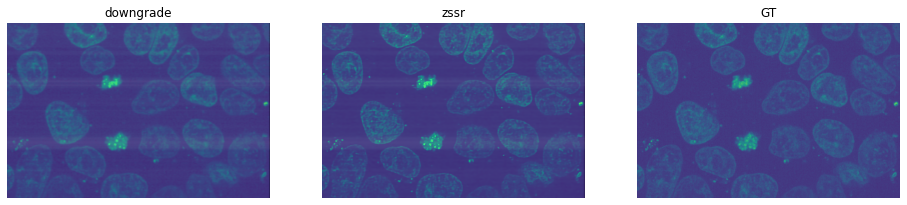

In [50]:
fig=plt.figure()
fig.add_subplot(1, 3, 1)
plt.title("downgrade")
plt.imshow(y)
plt.axis("off")
fig.add_subplot(1, 3, 2)
plt.title("zssr")
plt.imshow(zssr)
plt.axis("off")
fig.add_subplot(1, 3, 3)
plt.title("GT")
plt.imshow(x)
plt.axis("off")
plt.show()

In [51]:
def segment2d(x):
    struct_img0 = x[:,:,:].copy()
    ################################
    ## PARAMETERS for this step ##
    intensity_scaling_param = [1.5, 0.5]
    gaussian_smoothing_sigma = 1
#     print(suggest_normalization_param(struct_img0))
    ################################
    # intensity normalization
    struct_imgA = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

    # smoothing with 2d gaussian filter slice by slice 
#     structure_img_smooth1 = image_smoothing_gaussian_3d(struct_imgA, sigma=gaussian_smoothing_sigma)
    structure_img_smooth1 = edge_preserving_smoothing_3d(struct_imgA)
    ################################
    ## PARAMETERS for this step ##
    f2_param = [[1.5, 0.1]]
    ################################

    bw = filament_2d_wrapper(structure_img_smooth1, f2_param)
    ################################
    ## PARAMETERS for this step ##
    minArea = 5
    ################################

    seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)
    out=seg.astype(np.uint8)
    plt.imshow(out[:,:,0:1])
    return out[:,:,0:4]

In [58]:
def segment3d(x):
    struct_img0 = x[:,:,:].copy()
    ################################
    ## PARAMETERS for this step ##
    intensity_scaling_param = [1.5, 0.5]
    gaussian_smoothing_sigma = 1
    ################################
    # intensity normalization
    struct_imgA = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

    # smoothing with 2d gaussian filter slice by slice 
    structure_img_smooth1 = image_smoothing_gaussian_3d(struct_imgA, sigma=gaussian_smoothing_sigma)
    ################################
    ## PARAMETERS for this step ##
    f2_param = [[1.5, 0.04]]
    ################################

    bw = filament_3d_wrapper(structure_img_smooth1, f2_param)
    ################################
    ## PARAMETERS for this step ##
    minArea = 5
    ################################

    seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)
    out=seg.astype(np.uint8)
    plt.imshow(out[:,:,3:4])
    return out[:,:,0:5]

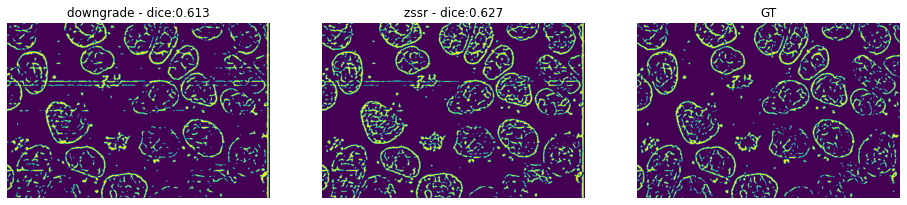

In [59]:
fig=plt.figure()
fig.add_subplot(1, 3, 1)
plt.title("downgrade - dice:0.613")
plt.imshow(segment3d(y))
plt.axis("off")
fig.add_subplot(1, 3, 2)
plt.title("zssr - dice:0.627")
plt.imshow(segment3d(zssr))
plt.axis("off")
fig.add_subplot(1, 3, 3)
plt.title("GT")
plt.imshow(segment3d(x))
plt.axis("off")
plt.show()

In [60]:
def compute_dice_coefficient(mask_gt, mask_pred):
  """Computes soerensen-dice coefficient.

  compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
  and the predicted mask `mask_pred`.

  Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.

  Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
  """
  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  return 2*volume_intersect / volume_sum 

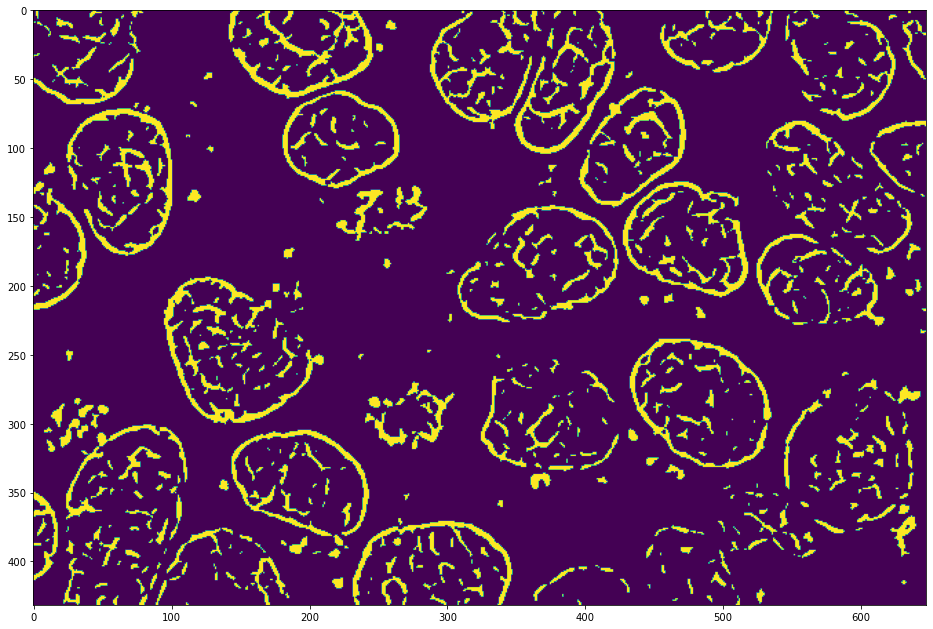

In [61]:
d=(segment3d(x).shape[1],segment3d(x).shape[0])

0.7116982924249293

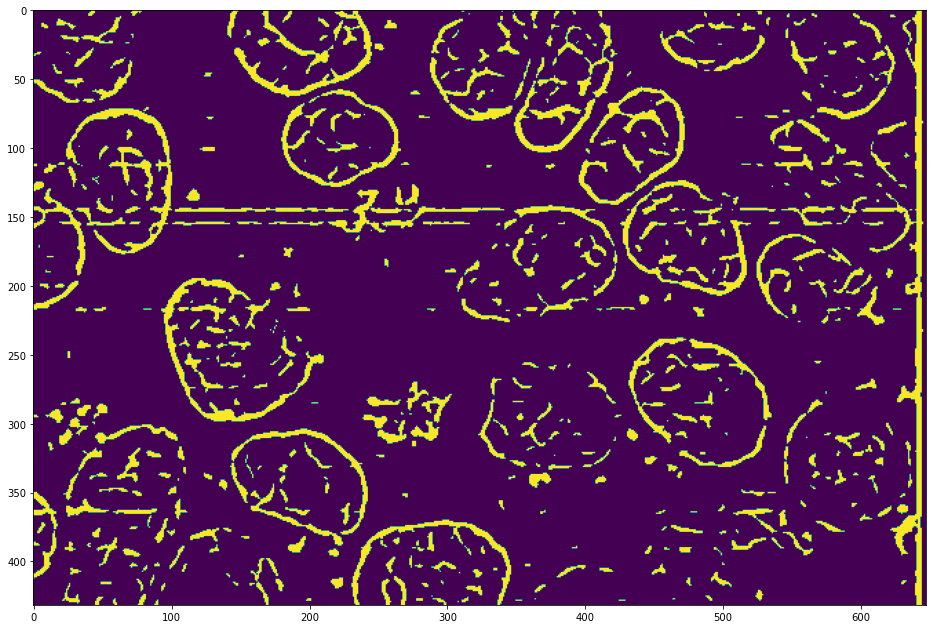

In [62]:
compute_dice_coefficient(segment3d(x), segment3d(cv2.resize(y,d)))

0.7321896011907817

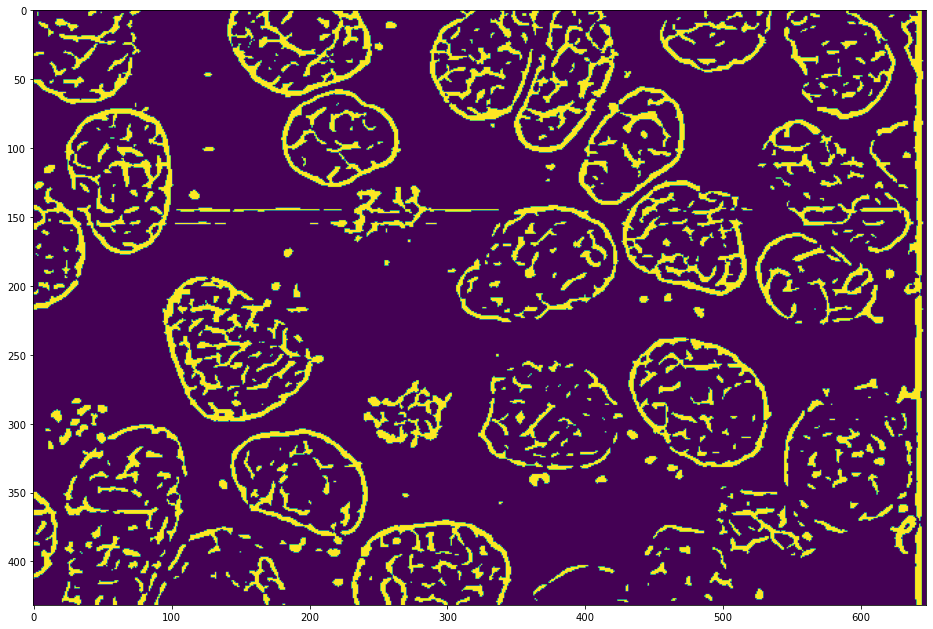

In [63]:
compute_dice_coefficient(segment3d(x), segment3d(cv2.resize(zssr,d)))

array([[[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        ...,
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        ...,
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        ...,
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

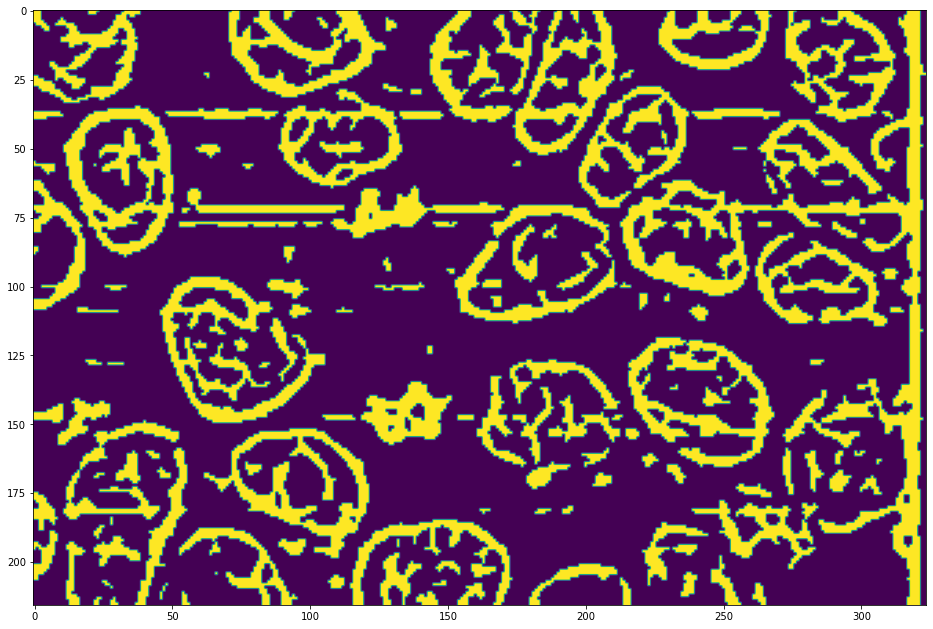

In [59]:
segment3d(y)

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

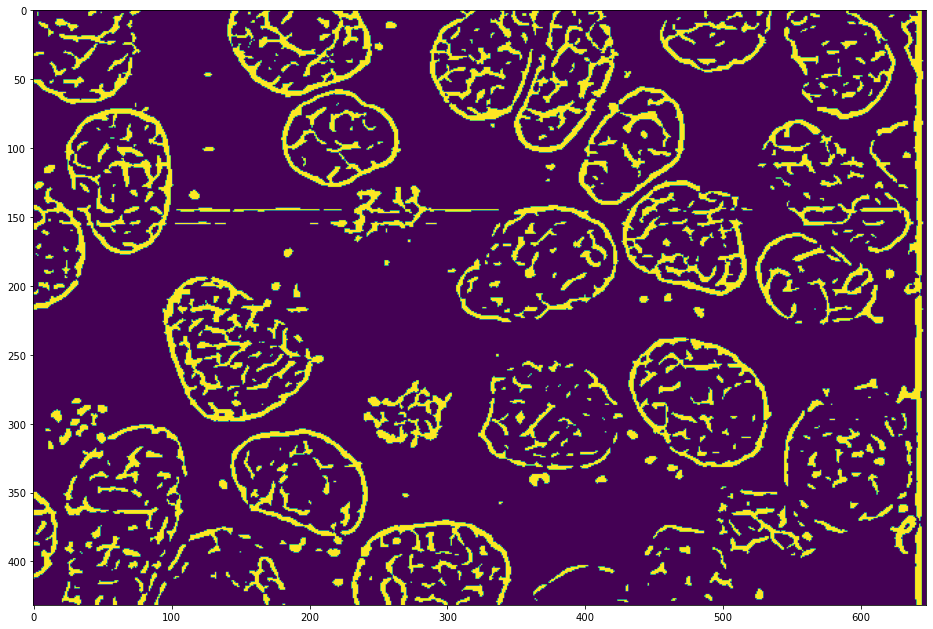

In [60]:
segment3d(zssr)

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 1],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 1],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

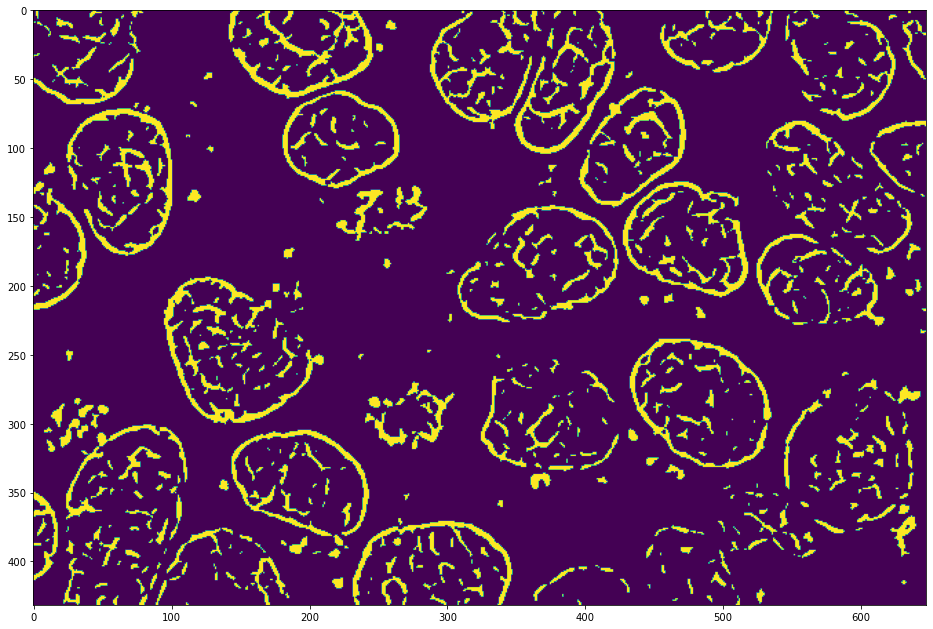

In [61]:
segment3d(x)